## Explore ProPublica Data for Recidivism Risk Models

Mucun Tian

### Load library

In [1]:
library(tidyverse)
library(plotROC)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


ERROR: Error in library(plotROC): there is no package called ‘plotROC’


options

In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)

### Load data

In [34]:
raw_data = read_csv("./compas-scores-two-years.csv")
raw_data %>%
 nrow()

Warning message:
“Duplicated column names deduplicated: 'decile_score' => 'decile_score_1' [40], 'priors_count' => 'priors_count_1' [49]”Parsed with column specification:
cols(
  .default = col_character(),
  id = col_integer(),
  compas_screening_date = col_date(format = ""),
  dob = col_date(format = ""),
  age = col_integer(),
  juv_fel_count = col_integer(),
  decile_score = col_integer(),
  juv_misd_count = col_integer(),
  juv_other_count = col_integer(),
  priors_count = col_integer(),
  days_b_screening_arrest = col_integer(),
  c_jail_in = col_datetime(format = ""),
  c_jail_out = col_datetime(format = ""),
  c_offense_date = col_date(format = ""),
  c_arrest_date = col_date(format = ""),
  c_days_from_compas = col_integer(),
  is_recid = col_integer(),
  r_days_from_arrest = col_integer(),
  r_offense_date = col_date(format = ""),
  r_jail_in = col_date(format = ""),
  r_jail_out = col_date(format = "")
  # ... with 13 more columns
)
See spec(...) for full column specificatio

[1] 7214

### Filtering data

In [35]:
df = raw_data %>% 
    filter(days_b_screening_arrest <= 30) %>%
    filter(days_b_screening_arrest >= -30) %>%
    filter(is_recid != -1) %>%
    filter(c_charge_degree != "O") %>%
    filter(score_text != 'N/A') %>%
    select(race, sex, decile_score, score_text, is_recid, v_decile_score, v_score_text, is_violent_recid)

In [36]:
summary(df)

     race               sex             decile_score     score_text       
 Length:6172        Length:6172        Min.   : 1.000   Length:6172       
 Class :character   Class :character   1st Qu.: 2.000   Class :character  
 Mode  :character   Mode  :character   Median : 4.000   Mode  :character  
                                       Mean   : 4.419                     
                                       3rd Qu.: 7.000                     
                                       Max.   :10.000                     
    is_recid      v_decile_score   v_score_text       is_violent_recid
 Min.   :0.0000   Min.   : 1.000   Length:6172        Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.: 1.000   Class :character   1st Qu.:0.0000  
 Median :0.0000   Median : 3.000   Mode  :character   Median :0.0000  
 Mean   :0.4844   Mean   : 3.642                      Mean   :0.1121  
 3rd Qu.:1.0000   3rd Qu.: 5.000                      3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :10.000                 

In [67]:
df = df %>%
    mutate(is_recid=is_recid==1,
           is_violent_recid=is_violent_recid==1,
           score_text=factor(score_text, levels=c("Low","Medium","High")),
           v_score_text=factor(v_score_text, levels=c("Low","Medium","High")))

Plot ROC curves for recidivism

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

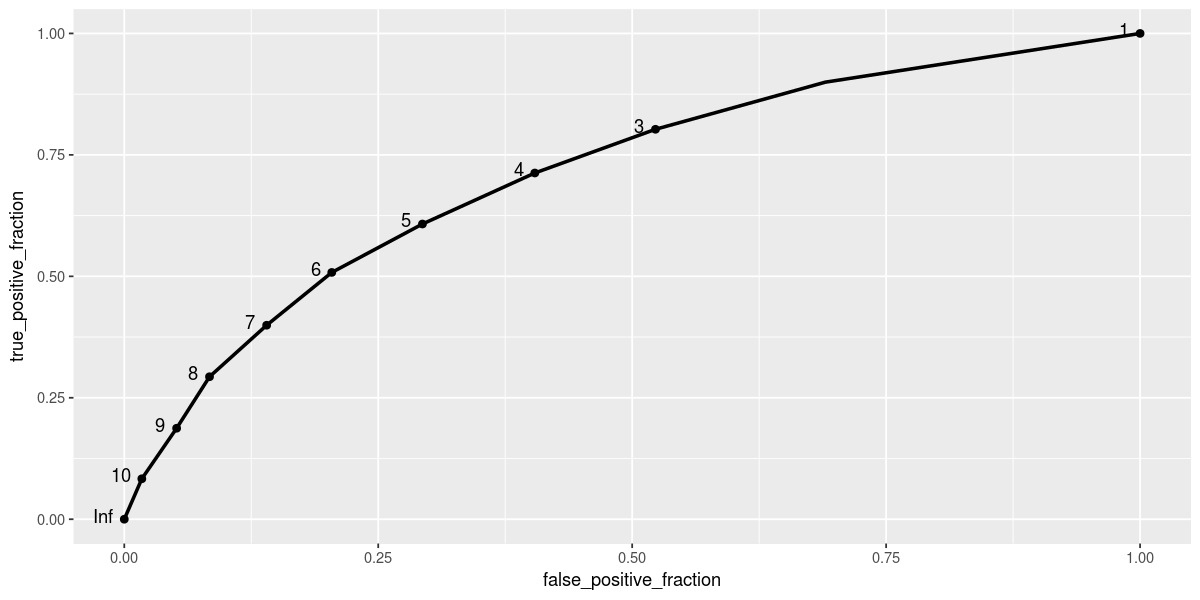

In [68]:
roc_plot = ggplot(df) +
    aes(d=is_recid, m=decile_score) +
    geom_roc()
roc_plot

Plot ROC curves for violent recidivism

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

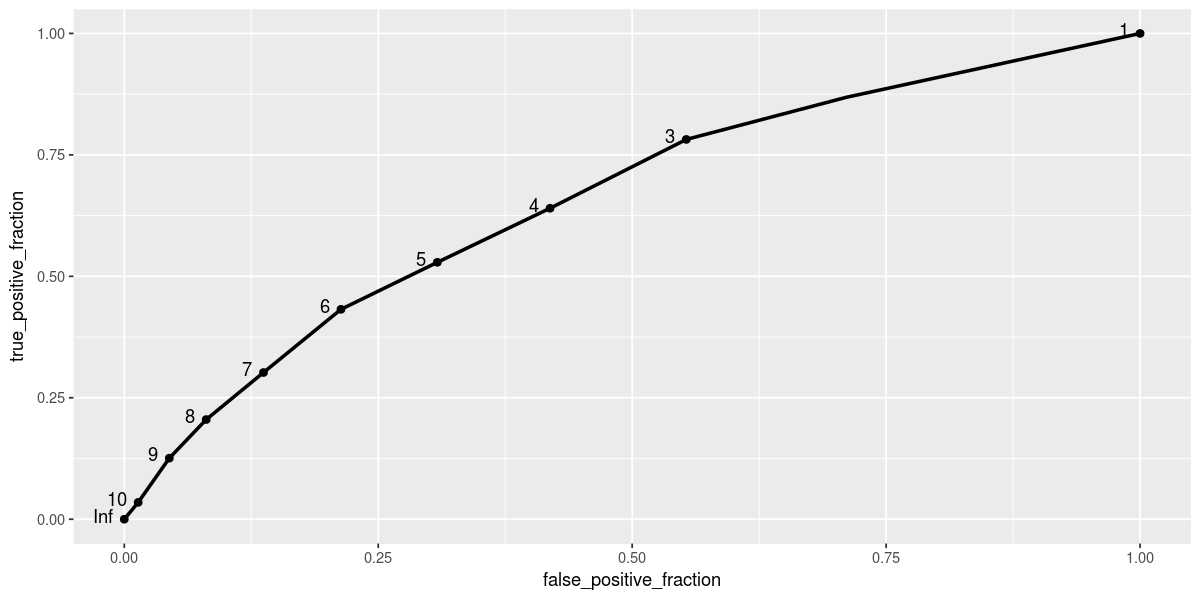

In [69]:
roc_plot = ggplot(df) +
    aes(d=is_violent_recid, m=v_decile_score) +
    geom_roc()
roc_plot

Compute the precision, recall, false positive rate, and false negative rate

"High Risk" is used as threshold for "will recidivate", and _positive_ is _'will recidivate'_

Add prediction columns: "High" for predict positive (will_recid), "Low" for predict negative (not_recid)

In [70]:
df = df %>%
    mutate(pred_recid=score_text=="High",
           pred_violent_recid=v_score_text=="High",
           pred_low=score_text=="Low",
           pred_violent_low=v_score_text=="Low")

**Precision**

Recidivism

In [71]:
df %>%
    filter(score_text=="High") %>%
    group_by(score_text) %>%
    summarize(Precision=mean(is_recid)) %>%
    ungroup()

score_text,Precision
High,0.7666084


violent recidivism

In [72]:
df %>%
    filter(v_score_text=="High") %>%
    group_by(v_score_text) %>%
    summarize(Precision=mean(is_violent_recid)) %>%
    ungroup()

v_score_text,Precision
High,0.2431507


**Recall**

Recidivism

In [73]:
df %>%
    filter(is_recid==TRUE) %>%
    group_by(is_recid) %>%
    summarize(Recall=mean(pred_recid)) %>%
    ungroup()

is_recid,Recall
TRUE,0.293311


violent recidivism

In [74]:
df %>%
    filter(is_violent_recid==TRUE) %>%
    group_by(is_violent_recid) %>%
    summarize(Recall=mean(pred_violent_recid)) %>%
    ungroup()

is_violent_recid,Recall
TRUE,0.2052023


**Fasle Positive Rate**

Recidivism

In [75]:
df %>%
    filter(is_recid==FALSE) %>%
    group_by(is_recid) %>%
    summarize(FaslePositiveRate=mean(pred_recid)) %>%
    ungroup()

is_recid,FaslePositiveRate
FALSE,0.08390949


violent recidivism

In [76]:
df %>%
    filter(is_violent_recid==FALSE) %>%
    group_by(is_violent_recid) %>%
    summarize(FaslePositiveRate=mean(pred_violent_recid)) %>%
    ungroup()

is_violent_recid,FaslePositiveRate
FALSE,0.08065693


**False Negative Rate**

Recidivism

In [77]:
df %>%
    filter(is_recid==TRUE) %>%
    group_by(is_recid) %>%
    summarize(FasleNegativeRate=mean(pred_low)) %>%
    ungroup()

is_recid,FasleNegativeRate
TRUE,0.3923077


violent recidivism

In [78]:
df %>%
    filter(is_violent_recid==TRUE) %>%
    group_by(is_violent_recid) %>%
    summarize(FasleNegativeRate=mean(pred_violent_low)) %>%
    ungroup()

is_violent_recid,FasleNegativeRate
TRUE,0.4710983


We want to look at racial disparities among groups: _Caucasian_, _Black_, and _Hispanic_.

filter data

In [79]:
df.race = df %>% filter(race %in% c("African-American", "Caucasian", "Hispanic"))

1. The likelihood that a defendant with each of the three risk score levels recidivates.

In [80]:
recid.likelihood = df.race %>% 
    select(race, score_text, is_recid) %>%
    group_by(race, score_text) %>%
    summarize(recid_likelihood=mean(is_recid)) %>%
    ungroup()

v.recid.likelihood = df.race %>% 
    select(race, v_score_text, is_violent_recid) %>%
    group_by(race, v_score_text) %>%
    summarize(v_recid_likelihood=mean(is_violent_recid)) %>%
    ungroup() %>%
    rename(score_text=v_score_text,
           recid_likelihood=v_recid_likelihood)

likelihood = bind_rows(Recidivism=recid.likelihood,
          ViolentRecidivism=v.recid.likelihood,
          .id="RecidivismType")

Barplot of the likelihood

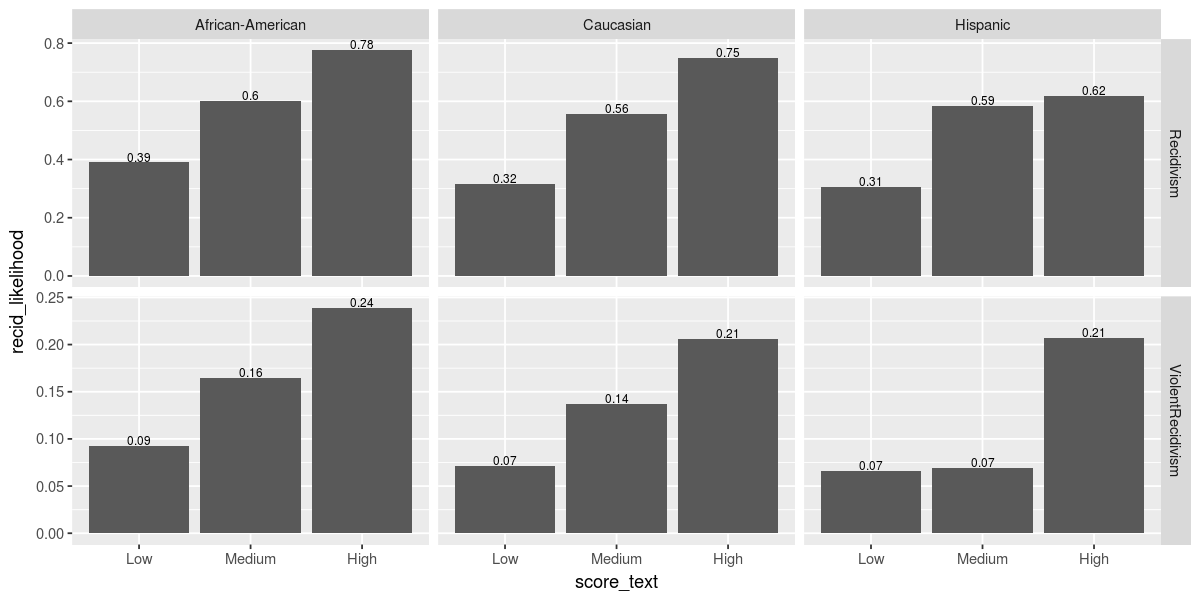

In [81]:
ggplot(likelihood) +
    aes(x=score_text, y=recid_likelihood) + 
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(recid_likelihood,2)), 
                          vjust=-0.1, 
                          size=2.5) +
    facet_grid(RecidivismType~race, scales="free")

It looks like the likelihood trend matches the prediction risk score level. High level has high likelihood of recidivate.

2.Compute the False Positive Rate for each race

In [82]:
recid.fp = df.race %>%
    filter(is_recid==FALSE) %>%
    group_by(race) %>% 
    summarize(FaslePositiveRate=mean(pred_recid)) %>%
    ungroup()

v.recid.fp = df.race %>%
    filter(is_violent_recid==FALSE) %>%
    group_by(race) %>% 
    summarize(FaslePositiveRate=mean(pred_violent_recid)) %>%
    ungroup()

race.recid.fp = bind_rows(Recidivism=recid.fp,
          ViolentRecidivism=v.recid.fp,
          .id="RecidivismType")
race.recid.fp

RecidivismType,race,FaslePositiveRate
Recidivism,African-American,0.13552068
Recidivism,Caucasian,0.04556550
Recidivism,Hispanic,0.05769231
ViolentRecidivism,African-American,0.12149873
ViolentRecidivism,Caucasian,0.04016693
ViolentRecidivism,Hispanic,0.04883227


Barplot of the False Positive Rate

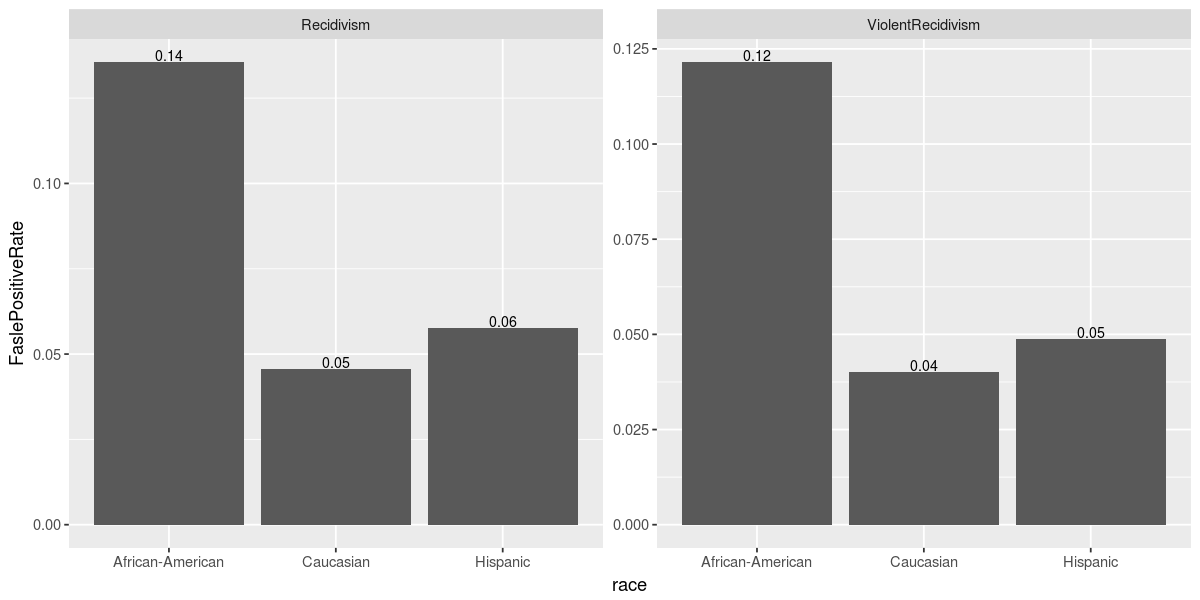

In [83]:
ggplot(race.recid.fp) +
    aes(x=race, y=FaslePositiveRate) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(FaslePositiveRate,2)), 
                          vjust=-0.1, 
                          size=3) +
    facet_wrap(~RecidivismType, scales="free")

3.Compute the False Negative Rate for each race

In [54]:
recid.fn = df.race %>%
    filter(is_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(FasleNegativeRate=mean(pred_low)) %>%
    ungroup()

v.recid.fn = df.race %>%
    filter(is_violent_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(FasleNegativeRate=mean(pred_violent_low)) %>%
    ungroup()

race.recid.fn = bind_rows(Recidivism=recid.fn,
          ViolentRecidivism=v.recid.fn,
          .id="RecidivismType")
race.recid.fn

RecidivismType,race,FasleNegativeRate
Recidivism,African-American,0.2961083
Recidivism,Caucasian,0.5080092
Recidivism,Hispanic,0.5736041
ViolentRecidivism,African-American,0.3873239
ViolentRecidivism,Caucasian,0.6290323
ViolentRecidivism,Hispanic,0.6578947


Barplot of the False Negative Rate for each race

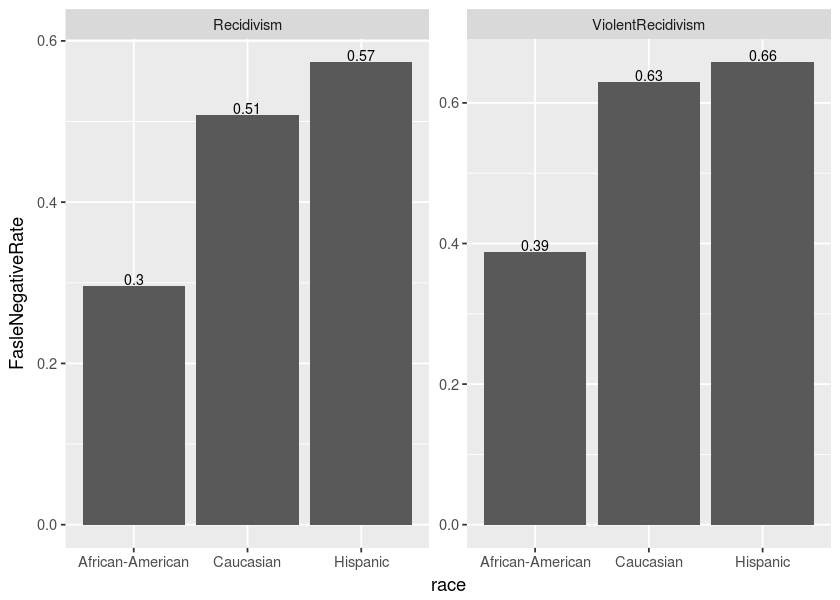

In [55]:
ggplot(race.recid.fn) +
    aes(x=race, y=FasleNegativeRate) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(FasleNegativeRate,2)), 
                          vjust=-0.1, 
                          size=3) +
    facet_wrap(~RecidivismType, scales="free")

4.Compute the Positive Predictive Value (Precision) for each race

In [56]:
recid.PPV = df.race %>%
    filter(pred_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(PPV=mean(is_recid)) %>%
    ungroup()

v.recid.PPV = df.race %>%
    filter(pred_violent_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(PPV=mean(is_violent_recid)) %>%
    ungroup()

race.recid.PPV = bind_rows(Recidivism=recid.PPV,
                           ViolentRecidivism=v.recid.PPV,
                           .id="RecidivismType")
race.recid.PPV

RecidivismType,race,PPV
Recidivism,African-American,0.7751479
Recidivism,Caucasian,0.7488789
Recidivism,Hispanic,0.6170213
ViolentRecidivism,African-American,0.2391800
ViolentRecidivism,Caucasian,0.2061856
ViolentRecidivism,Hispanic,0.2068966


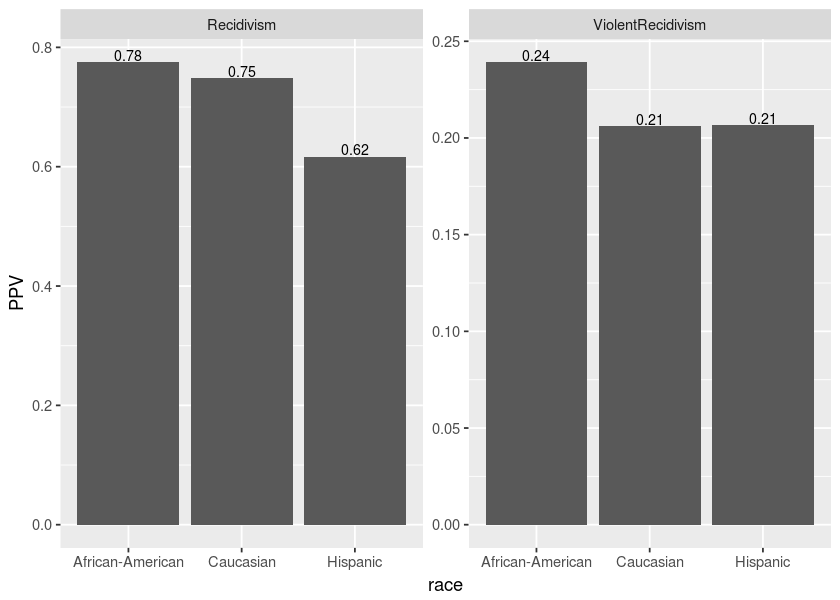

In [57]:
ggplot(race.recid.PPV) +
    aes(x=race, y=PPV) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(PPV,2)), 
                          vjust=-0.1, 
                          size=3) +
    facet_wrap(~RecidivismType, scales="free")

5.Compute the Negative Predictive Value for each race

In [61]:
recid.NPV = df.race %>%
    filter(pred_low==TRUE) %>%
    group_by(race) %>% 
    summarize(NegativePredictiveValue=mean(is_recid)) %>%
    ungroup()

v.recid.NPV = df.race %>%
    filter(pred_violent_low==TRUE) %>%
    group_by(race) %>% 
    summarize(NegativePredictiveValue=mean(is_violent_recid)) %>%
    ungroup()

race.recid.NPV = bind_rows(Recidivism=recid.NPV,
                           ViolentRecidivism=v.recid.NPV,
                           .id="RecidivismType")
race.recid.NPV

RecidivismType,race,NegativePredictiveValue
Recidivism,African-American,0.39004458
Recidivism,Caucasian,0.31556503
Recidivism,Hispanic,0.30706522
ViolentRecidivism,African-American,0.09223030
ViolentRecidivism,Caucasian,0.07099515
ViolentRecidivism,Hispanic,0.06596306


Barplot

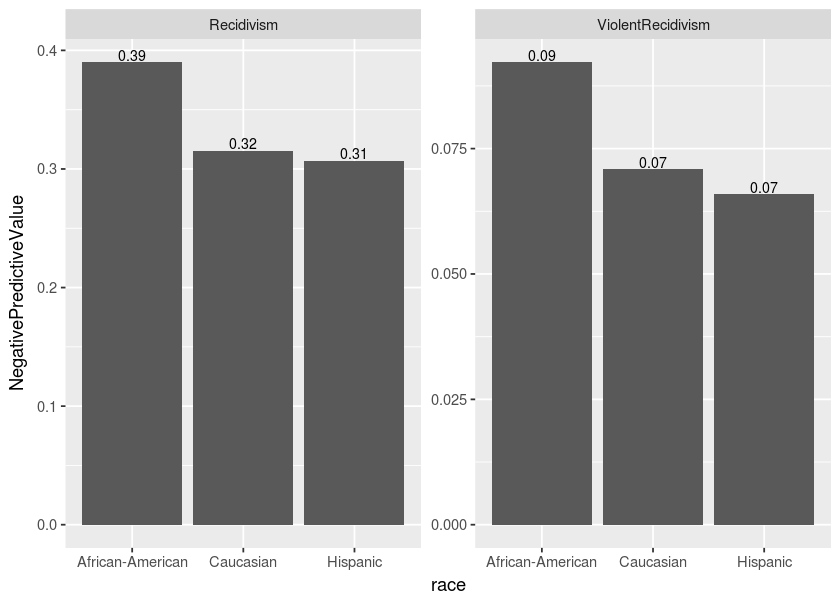

In [62]:
ggplot(race.recid.NPV) +
    aes(x=race, y=NegativePredictiveValue) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(NegativePredictiveValue,2)), 
                          vjust=-0.1, 
                          size=3) +
    facet_wrap(~RecidivismType, scales="free")

6.Plot ROC for each race

In [63]:
recid.roc = df.race %>%
    select(is_recid, decile_score, race)

v.recid.roc = df.race %>%
    select(is_violent_recid, v_decile_score, race) %>%
    rename(is_recid=is_violent_recid,
           decile_score=v_decile_score)

race.recid.roc = bind_rows(Recidivism=recid.roc,
                           ViolentRecidivism=v.recid.roc,
                           .id="RecidivismType")
race.recid.roc

RecidivismType,is_recid,decile_score,race
Recidivism,TRUE,3,African-American
Recidivism,TRUE,4,African-American
Recidivism,TRUE,6,Caucasian
Recidivism,FALSE,1,Caucasian
Recidivism,FALSE,4,Caucasian
⋮,⋮,⋮,⋮
ViolentRecidivism,FALSE,9,African-American
ViolentRecidivism,FALSE,5,African-American
ViolentRecidivism,FALSE,5,African-American
ViolentRecidivism,FALSE,2,African-American


In [64]:
options(repr.plot.width=10)

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

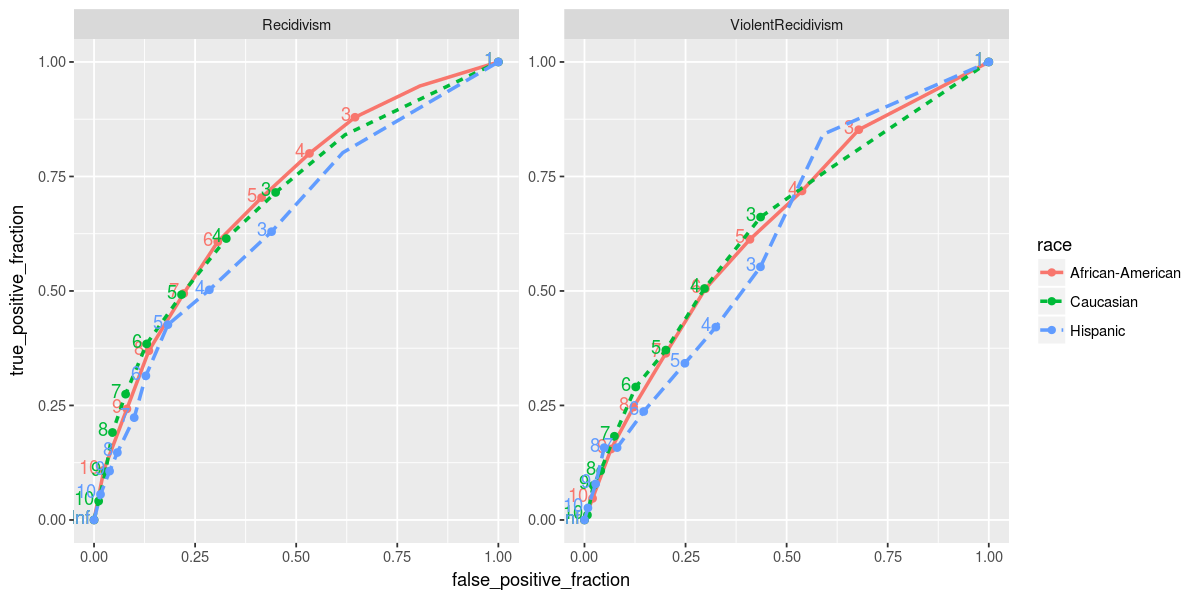

In [65]:
roc_plot = ggplot(race.recid.roc) +
    aes(d=is_recid, m=decile_score, color=race, linetype=race) +
    geom_roc() +
    facet_wrap(~RecidivismType, scales="free")
roc_plot

In [66]:
calc_auc(roc_plot)

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

PANEL,group,AUC
1,1,0.7018905
1,2,0.6914968
1,3,0.6478101
2,1,0.6383431
2,2,0.6369047
2,3,0.6195664


### Discussion

1. members of different races's experience of the prediction systems
    - False Positive Rate: African-American has highest false positive rate (0.14), the second one is Hispanic group(0.06), the last one is Caucasian (0.05). It seems that the judgment for **_"will recidivate"_** made by this prediction system is much more **strict for African-American** group than the other two groups. 
    - False Negative Rate: Hispanic group has highest score(0.57), the second one is Caucasian (0.51), and the last one is African-American group (0.3). It seems that the judgment of **_"will not recidivate"_** is much more loose for Hispanic and Caucasian group than for the African-American group. It shows that more than half of Hispanic and Caucasian people who actually recidivate were predicted as **"will not recidivate"**
    - Positive Predictive Value: 0.78, 0.75, 0.62 for African-American, Caucasian and Hispanic group respectively. It shows that all the group have similar experience on positive predictive vaule.
    - Negative Predictive Value: 0.39, 0.32, 0.31 for African-American, Caucasian and Hispanic group respectively. It shows that all the group have similar experience based on error of predict negative cases.
2. Because the condition given to compute FPR and PPV is different. 
    - FPR is to compute False Positive given all the defendants who actually does not recidivate, so this is looking at the reality domain. 
    - However the PPV is to compute the True Positive given all the predicted "will recidivate", so this is looking at the prediction domain.

Let's compute the count number of False Negative, True Positive, and False Positive

FN

In [85]:
df.race %>%
    filter(is_recid==TRUE & pred_low==TRUE) %>%
    group_by(race) %>% 
    summarize(Count=n()) %>%
    ungroup()

race,Count
African-American,525
Caucasian,444
Hispanic,113


TP

In [86]:
df.race %>%
    filter(is_recid==TRUE & pred_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(Count=n()) %>%
    ungroup()

race,Count
African-American,655
Caucasian,167
Hispanic,29


FP

In [87]:
df.race %>%
    filter(is_recid==FALSE & pred_recid==TRUE) %>%
    group_by(race) %>% 
    summarize(Count=n()) %>%
    ungroup()

race,Count
African-American,190
Caucasian,56
Hispanic,18


From above, we can see FP and TP have similar proportion for each group, this makes the PPV similar. However, for FN, the number of Caucasian and Hispanic group increased a lot, this makes the proportion be not similar to TP. So the FNR is not similar. 